Copyright (C) 2024 Konstantin Touev  
All Rights Reserved.

Do the imports -> we use the standard project imports as we verify project solutions 

In [1]:
import datetime
from IPython.display import display

from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field

if __name__ == "__main__":
    from dotenv import load_dotenv

    load_dotenv()

import pandas as pd
from pandas import Timedelta
from langchain import PromptTemplate
import matplotlib.pyplot as plt

from file_processing.document_processor.summarisation_utils import chunk_into_semantic_chapters
from file_processing.embeddings import pending_embeddings_singleton, BGEM3Flag
from file_processing.llm_chat_support import get_llm, LLMTemp, LLMTypes

/u/halle/tou/home_at/IdeaProjects/thesis_backend/venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


Prepare dataset and tools

In [2]:
# First load the CSV
# Originally from https://huggingface.co/datasets/recapper/Course_summaries_dataset
# I choose this dataset as it had timestamped transcriptions and human-entered chapters for the videos

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
# Read the whole text fields
pd.set_option('display.max_colwidth', None)

transcripts_df = pd.read_excel('fsdl_2022_project_transcripts.xlsx', sheet_name='lesson_transcripts', index_col=0).reset_index(drop=True)
human_chapters_df = pd.read_excel('fsdl_2022_project_transcripts.xlsx', sheet_name='lesson_topics', index_col=0).reset_index(drop=True)


def timestamp_to_seconds(timestamp: Timedelta | str) -> float:
    if isinstance(timestamp, str):
        # Excel has the field correctly formatted as Timedelta, but sometimes it is str
        x = datetime.datetime.strptime(timestamp, '%H:%M:%S')
        seconds = x.hour * 3600 + x.minute * 60 + x.second
        return seconds
    return timestamp.total_seconds()

# Some rows are empty
transcripts_df = transcripts_df.dropna()
human_chapters_df = human_chapters_df.dropna()

transcripts_df['start_time'] = transcripts_df['timestamp'].apply(timestamp_to_seconds)
human_chapters_df['start_time'] = human_chapters_df['timestamp'].apply(timestamp_to_seconds)

transcripts_df = transcripts_df.sort_values(by='start_time')
human_chapters_df = human_chapters_df.sort_values(by='start_time')

video_urls = transcripts_df['video_url'].unique().tolist()

# video_urls = video_urls[0:3]

print(f"We have {len(video_urls)} videos in dataset:")
display(pd.DataFrame({'VideoURL': video_urls[:]}))

human_chapters_transcript_data = []
for video_url in video_urls:
    human_chapters_per_video_df = human_chapters_df[human_chapters_df['video_url'] == video_url].copy()
    # Next start is this's end
    human_chapters_per_video_df['end_time'] = human_chapters_per_video_df['start_time'].shift(-1)
    # Last transcript end is last start + 40 secs
    human_chapters_per_video_df.at[human_chapters_per_video_df.index[-1], 'end_time'] = transcripts_df[
        (transcripts_df['video_url'] == video_url)
    ]['start_time'].max() + 60
    # Chapters are not always from 0 and we might miss the intro
    human_chapters_per_video_df.at[human_chapters_per_video_df.index[0], 'start_time'] = 0
    for _, row in human_chapters_per_video_df.iterrows():
        start_time = row['start_time']
        end_time = row['end_time']
        chapter_transcripts = transcripts_df[
            (transcripts_df['start_time'] >= start_time) 
             & (transcripts_df['start_time'] < end_time)
             & (transcripts_df['video_url'] == video_url)
            ]
        chapter_text = ' '.join(chapter_transcripts['transcript'].apply(lambda x: str(x)).tolist())
        human_chapters_transcript_data.append({
            'video_url': video_url,
            'title': row['topic'],
            'chapter_text': chapter_text
        })
human_chapters_transcript_df = pd.DataFrame(human_chapters_transcript_data)

#print("Transcripts for video:")
#display(transcripts_df)
#print("Human chapters for video:")
#display(human_chapters_df)
#print("Human chapters and their transcript per video:")
#display(human_chapters_transcript_df)

# Define LLM-globals
class ScoreFormat(BaseModel):
    rating: int = Field(description="Rating from 0 to 100")
    arguments: str = Field(description="Arguments explaining why the rating was chosen")


structured_model = (get_llm(LLMTemp.CONCRETE, LLMTypes.BIG_VISUAL_MODEL)
                    .with_structured_output(ScoreFormat, method="json_mode"))

pending_embeddings_singleton.init_mode(BGEM3Flag())

output_parser = PydanticOutputParser(pydantic_object=ScoreFormat)

We have 38 videos in dataset:


,VideoURL
0,https://youtu.be/F4tvM4Vb3A0
1,https://youtu.be/toUgBQv1BT8
2,https://www.youtube.com/watch?v=lwCRjwDs1Ek
3,https://www.youtube.com/watch?v=P7fHYSyvxU0
4,https://www.youtube.com/watch?v=cB1c2LB6_hg
5,https://youtu.be/2b0TPDmzoaQ
6,https://youtu.be/yhAmMUi2NmM
7,https://youtu.be/pxisK6RMn1s
8,https://youtu.be/fGxWfEuUu0w
9,https://youtu.be/hBBOjCiFcuo


Fetching 30 files: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84790.51it/s]
/u/halle/tou/home_at/IdeaProjects/thesis_backend/venv/lib/python3.10/site-packages/FlagEmbedding/BGE_M3/modeling.py:335: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` fo

For evaluation, we do 4 things -> titles for semantic chapter, rate human titles, rate chapter division and evaluate semantic vs human chapters directly.

Step 1: Generate titles for the semantic chapter  
We do that so we have a human-readable representation of the split

In [3]:
from langchain_core.messages import AIMessage

semantic_chapter_df = pd.DataFrame(columns=['video_url', 'title', 'chapter_text'])

for video_url in list(video_urls):
    try:
        transcripts_video_df = transcripts_df[
            (transcripts_df['video_url'] == video_url)
        ]
        # Sometimes we have wrong datatype for transcript
        transcript_text = ' '.join(transcripts_video_df['transcript'].apply(lambda x: str(x)).tolist())
        
        # Use default chunk size
        semantic_chapters = chunk_into_semantic_chapters(pending_embeddings_singleton, transcript_text)
        
        title_generation_prompt = PromptTemplate(
            input_variables=['chapter_text'],
            template="""
        Given the following chapter text, generate a concise and descriptive title for it.
        
        Chapter Text:
        {chapter_text}
        
        Title:
        """
        )
        
        semantic_chapter_per_video_data = []
        for idx, chapter_text in enumerate(semantic_chapters):
            title_msg: AIMessage = (
                        title_generation_prompt | get_llm(LLMTemp.CONCRETE, LLMTypes.BIG_VISUAL_MODEL)).invoke({
                "chapter_text": chapter_text
                # Title sometimes has quotes or may be using md formatting
            })
            title = title_msg.content.strip().strip('"').strip("'").strip('*')
            semantic_chapter_per_video_data.append({
                'video_url': video_url,
                'title': title,
                'chapter_text': chapter_text
            }) 
            
        semantic_chapter_per_video_df = pd.DataFrame(semantic_chapter_per_video_data)
        # print(f"Semantic chapters and their transcripts for video '{video_url}':")
        # display(semantic_chapter_per_video_df)
        print(f"Semantic chapters for video '{video_url}':")
        print(', '.join(semantic_chapter_per_video_df["title"].apply(lambda x: (x[:25] + '...') if len(x) > 30 else x).tolist()))
        semantic_chapter_df = pd.concat([semantic_chapter_df, semantic_chapter_per_video_df]).reset_index(drop=True)
    except Exception as e:
        print(f"Failed to add video '{video_url}' semantic chapters")
        print(e)
        video_urls.remove(video_url)
    

# print(f"Semantic chapters and their transcript per video:")
# display(semantic_chapter_df)

Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 294/294 [00:10<00:00, 27.96it/s]


Semantic chapters for video 'https://youtu.be/F4tvM4Vb3A0':
Lesson Two: Exciting New ..., Maximizing Learning: Util..., Showcasing Community Crea..., From Data Collection to P..., Efficient Navigation and ..., Revolutionary Approach to..., Enhancing Image Recogniti..., Real-Time Image Augmentat..., Understanding Model Confi..., Refining Data Sets: Ident..., Efficient Data Cleaning a..., Deploying Machine Learnin..., Setting Up Your Developme..., Setting Up a Cross-Platfo..., Deploying a Basic Gradio ..., Building and Exporting a ..., Deploying and Using Train..., Predicting Dog vs. Cat wi..., Building a Dog-Cat Classi..., Efficiently Converting Ju..., Deploying and Fine-Tuning..., Setting Up Your Machine f..., Setting Up a Safe and Eff..., Building and Deploying Ma..., Building and Integrating ..., Building Interactive Pet ..., Creating and Deploying a ..., Creating and Customizing ..., Hacker's Guide to Startin...


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:12<00:00, 28.34it/s]


Semantic chapters for video 'https://youtu.be/toUgBQv1BT8':
Exploring NLP with Huggin..., Deep Dive into Fine-Tunin..., Mastering Language Models..., Transitioning from Predic..., Understanding Layer Progr..., Building Real-World Deep ..., Exploring NLP: Document C..., Transforming Similarity A..., Optimizing Deep Learning ..., Essential Tools and Pract..., Exploring DataFrames with..., Transforming Text Data fo..., Understanding Tokenizatio..., Exploring Pre-trained NLP..., Understanding AutoTokeniz..., Understanding Tokenizatio..., Tokenization and Numerica..., Optimizing NLP for Long D..., Understanding Overfitting..., Exploring Underfitting in..., Understanding Overfitting..., Ensuring Model Accuracy: ..., Avoiding Overfitting: Les..., Navigating Validation and..., Understanding Metrics and..., Navigating the Pitfalls o..., Understanding the Pearson..., Understanding and Visuali..., Enhancing Scatter Plots w..., Understanding Correlation..., Data Splitting and Batch ..., Optimizing

Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:12<00:00, 28.50it/s]


Semantic chapters for video 'https://youtu.be/hBBOjCiFcuo':
Navigating Practical Deep..., Effective Self-Study Tech..., Exploring Innovative Idea..., Exploring Neural Networks..., Introducing a Full-Fledge..., Optimizing Model Training..., Evaluating Image Classifi..., Optimizing Image Classifi..., Understanding fastai's Mo..., Understanding Neural Netw..., Creating and Testing Quad..., Adding Noise to Data and ..., Optimizing Model Paramete..., Optimizing Parameters wit..., Calculating Gradients and..., Optimizing Parameters in ..., Introduction to Gradient ..., Constructing Complex Mode..., Demystifying Deep Learnin..., Optimizing Early-Stage Ma..., Early Model Training and ..., Understanding the Learnin..., Optimizing Learning Rates..., Demystifying Matrix Multi..., Building a Machine Learni..., Data Preprocessing and Fe..., Data Normalization and Lo..., Optimizing Linear Regress..., Introduction to Neural Ne..., Optimizing Deep Learning ..., Mastering Matrix Multipli..., Understand

Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:11<00:00, 23.23it/s]


Failed to add video 'https://youtu.be/AdhG64NF76E' semantic chapters
Azure has not provided the response due to a content filter being triggered
Semantic chapters for video 'https://www.youtube.com/watch?v=vhmtoAYVRSo':
The Science of Fasting: U..., Optimizing Health Through..., Health Benefits and Guide..., The Role of Cholesterol i...
Semantic chapters for video 'https://youtu.be/awnn-bqV_Tw':
Rebuilding from Scratch: ..., Building in Public: Provi..., Building a Business Aroun..., Building a Business You L..., Building Skills and Conne..., Building Your YouTube Car..., From Passion to Professio..., From Hourly Rates to Prod..., Scaling Solo: Building a ..., Unlocking Success: The Po..., Five Steps to Building a ...
Semantic chapters for video 'https://youtu.be/AoYD4eB3Vo4':
Exploring Ethics in Machi..., Exploring Ethical Theorie..., Ethical Dilemmas in the A..., Emerging Ethical Dilemmas..., Robots, AI, and the Futur..., AI Alignment: Ensuring Hu..., Navigating Bias in Machin..., Bi

Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:10<00:00, 24.27it/s]


Semantic chapters for video 'https://youtu.be/htiNBPxcXgo':
Final Lesson: Mastering C..., Automating Parameter Mana..., Understanding PyTorch Par..., Replicating PyTorch's Emb..., Understanding Model Train..., Understanding Movie Prefe..., Optimizing Movie Recommen..., Understanding Embeddings ..., Implementing Collaborativ..., Optimizing Embedding Size..., Challenges and Techniques..., Understanding Embedding M..., Building Tabular Neural N..., Kaggle Competition Insigh..., Leveraging Embeddings for..., Understanding Convolution..., Understanding Convolution..., Understanding Convolution..., Understanding Convolution..., Evolution of Convolutiona..., Stride 2 Convolution: Ski..., Advanced Pooling Techniqu..., Understanding Convolution..., Understanding Convolution..., Understanding Dropout Lay..., Key Concepts and Developm..., Maximizing Your Deep Lear..., Staying Motivated and Foc..., Balancing Innovation and ..., Integrating Technology in..., Turning ML Prototypes int..., Mastering 

Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 45.54it/s]


Semantic chapters for video 'https://www.youtube.com/watch?v=_SNUm2EqXOs':
Adrenal Glands: The Body'..., Navigating Toxic Personal..., The Impact of Stress on R..., Managing Adrenal Stress: ..., Understanding the Impact ..., Recovery: The Key to Effe..., The Hidden Impact of Adre..., Symptom vs. Cause: The Mi..., Redefining Food: Prioriti..., Creating Health: The Impo..., Craving Control: The Esse..., Understanding Adrenal Hea..., The Myth of Hydration and..., Adrenal Health and Grocer...


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 351/351 [00:13<00:00, 26.78it/s]


Semantic chapters for video 'https://youtu.be/p4ZZq0736Po':
Optimizing Neural Network..., Maximizing Success in Kag..., Optimizing GPU Memory Usa..., Optimizing Training Dynam..., Optimizing Training with ..., Understanding Gradient Ac..., Optimizing Batch Size and..., Optimizing Model Training..., Ensembling Diverse Archit..., Journey to the Top: Itera..., Exploring K-Fold Cross-Va..., Optimizing GPU Choices fo..., Model Distillation and Mu..., Advanced Data Handling wi..., Dual Labeling with get_y:..., Building a Multi-Output P..., Understanding Cross-Entro..., Understanding the Softmax..., Understanding Softmax and..., Understanding Cross-Entro..., Understanding Binary Cros..., Understanding PyTorch Los..., Expanding ConvNext_Small ..., Exploring the Benefits of..., Exploring Collaborative F..., Understanding Collaborati..., Predicting Movie Preferen..., Predicting Movie Preferen..., Optimizing Predictions wi..., Understanding Dot Product..., Demystifying Embeddings: ..., Building C

Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:10<00:00, 26.80it/s]


Semantic chapters for video 'https://youtu.be/8SF_h3xF3cE':
Building a Bird Recogniti..., Building a Computer Visio..., From Impossibility to Acc..., Creative AI: Transforming..., Bridging Art and AI: Inno..., Managing Online Class Par..., Radek's Journey and the F..., Introduction to Deep Lear..., Impact and Influence of t..., From Manual Feature Engin..., Automated Feature Detecti..., Creative Applications of ..., Debunking Deep Learning M..., Streamlining Deep Learnin..., Getting Started with Jupy..., Mastering Jupyter Noteboo..., Mastering Data Blocks: Th..., Building and Preparing Im..., Understanding Labeling Fu..., Building and Fine-Tuning ..., Efficient Image Segmentat..., Mastering Tabular Data An..., Understanding Collaborati..., Transforming Jupyter Note..., Deep Learning: The Power ..., Foundations and Evolution..., From Traditional Programm..., Iterative Improvement and..., Introduction to Python No..., Innovative Classification..., From Student Projects to ...
Semantic ch

Sanity check the chapter and transcript length

The length of the original video transcript is '62407' chars
The length of the semantic chapters for video 'https://youtu.be/F4tvM4Vb3A0' is '62407' chars
The length of the human chapters for video 'https://youtu.be/F4tvM4Vb3A0' is '62407' chars
----------------------------------------------------------------------------------------------------
The length of the original video transcript is '78276' chars
The length of the semantic chapters for video 'https://youtu.be/toUgBQv1BT8' is '78276' chars
The length of the human chapters for video 'https://youtu.be/toUgBQv1BT8' is '78276' chars
----------------------------------------------------------------------------------------------------
The length of the original video transcript is '7031' chars
The length of the semantic chapters for video 'https://www.youtube.com/watch?v=lwCRjwDs1Ek' is '7031' chars
The length of the human chapters for video 'https://www.youtube.com/watch?v=lwCRjwDs1Ek' is '7031' chars
---------------------------------

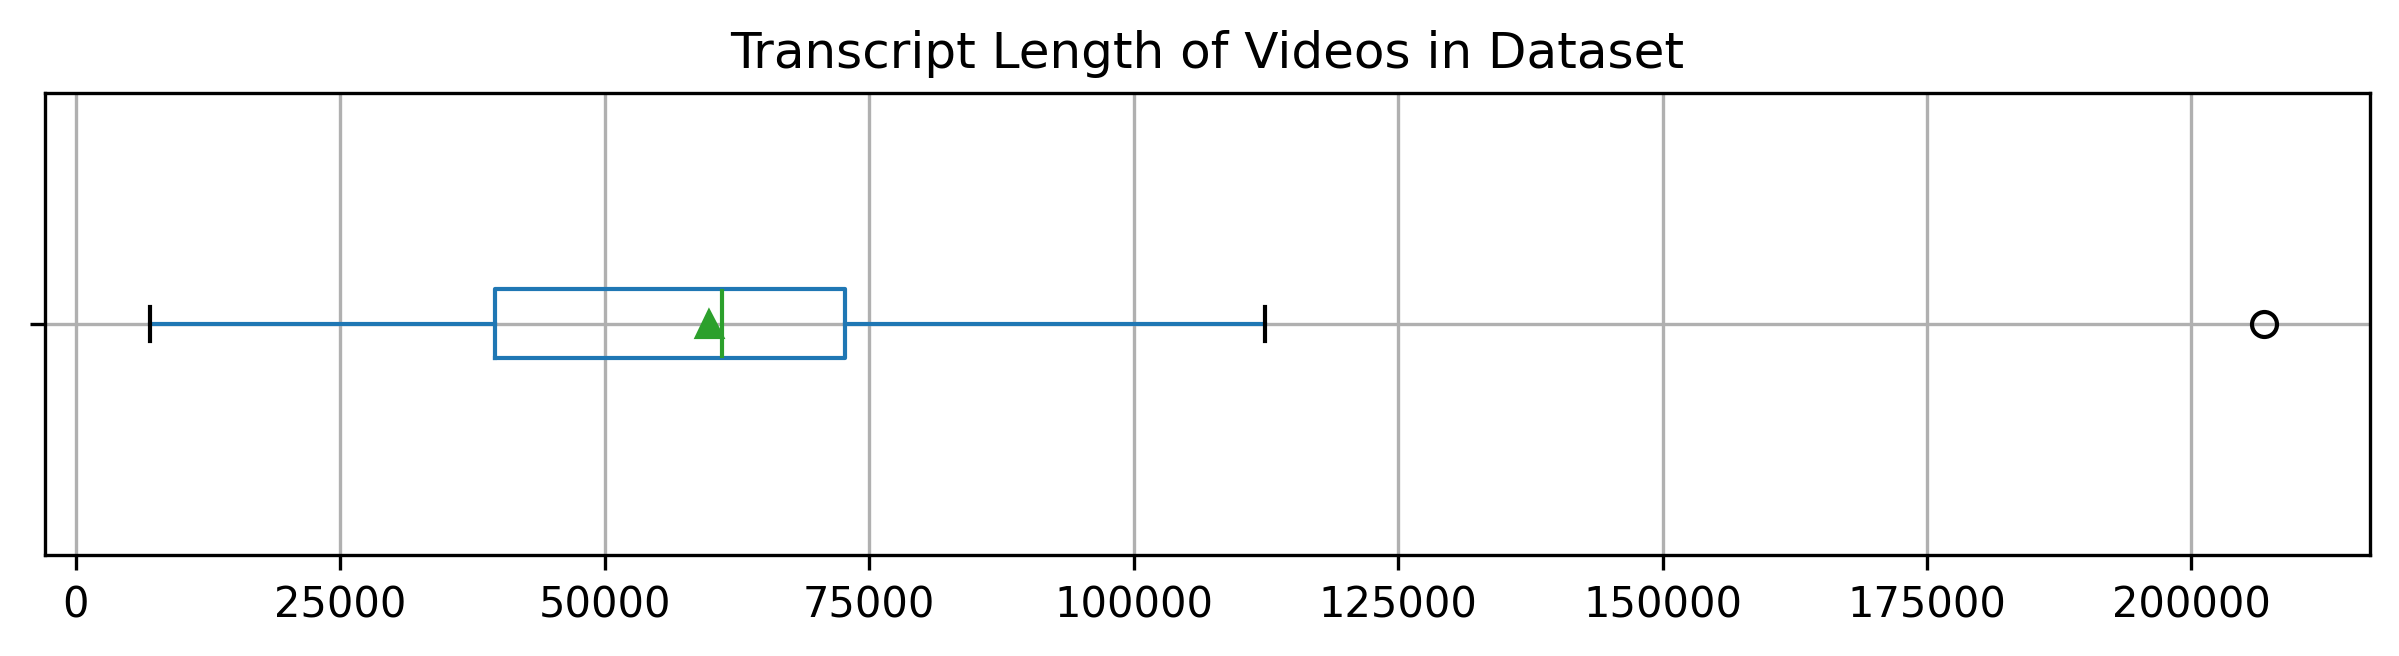

In [27]:
transcript_lengths = []
for video_url in video_urls:
    transcripts_video_df = transcripts_df[
        (transcripts_df['video_url'] == video_url)
    ]
    semantic_chapter_per_video_df = semantic_chapter_df[
        (semantic_chapter_df['video_url'] == video_url)
    ]
    human_chapters_transcript_per_video_df = human_chapters_transcript_df[
        (human_chapters_transcript_df['video_url'] == video_url)
    ]
    # Sometimes we have wrong datatype for transcript
    transcript_text = ' '.join(transcripts_video_df['transcript'].apply(lambda x: str(x)).tolist())

    print(f"The length of the original video transcript is '{len(transcript_text)}' chars")
    print(
        f"The length of the semantic chapters for video '{video_url}' is '{len(' '.join(semantic_chapter_per_video_df['chapter_text'].to_list()))}' chars")
    print(
        f"The length of the human chapters for video '{video_url}' is '{len(' '.join(human_chapters_transcript_per_video_df['chapter_text'].to_list()))}' chars")
    transcript_lengths.append({"transcript_length": len(transcript_text)})
    print("-" * 100)

transcript_lengths_df = pd.DataFrame(transcript_lengths)
fig, ax = plt.subplots(figsize=(10, 2), dpi=300)
transcript_lengths_df.boxplot(column='transcript_length', vert=False, showmeans=True, ax=ax)
ax.set_title('Transcript Length of Videos in Dataset')
plt.suptitle('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels([])
plt.show()

Step 2: Rate the human titles based on their transcript

In [5]:
human_title_ratings_df = pd.DataFrame(columns=['video_url', 'title', 'rating', 'arguments'])

for video_url in video_urls:
    title_rating_prompt = PromptTemplate(
        input_variables=['title', 'chapter_text'],
        partial_variables={'format_instructions': output_parser.get_format_instructions()},
        template="""
    Given the following chapter's text and its title, rate how well the title summarises the chapter from 0 to 100, where 0 is the worst and 100 is the best. Provide arguments why the rating is chosen.
    
    Chapter Text:
    {chapter_text}
    
    Chapter Title:
    {title}
    
    {format_instructions}
    """
    )
    
    human_title_ratings_per_video_data = []

    human_chapters_transcript_per_video_df = human_chapters_transcript_df[human_chapters_transcript_df['video_url'] == video_url]
    
    for _, chapter in human_chapters_transcript_per_video_df.iterrows():
        try:
            response = (title_rating_prompt | structured_model).invoke({
                "title": chapter['title'],
                "chapter_text": chapter['chapter_text']
            })
            human_title_ratings_per_video_data.append({
                'video_url': video_url,
                'title': chapter['title'],
                'rating': response.rating,
                'arguments': response.arguments
            })
        except Exception as e:
            print(f"Error rating title '{chapter['title']}' for video '{video_url}': {e}")
            human_title_ratings_per_video_data.append({
                'video_url': video_url,
                'title': chapter['title'],
                'rating': None,
                'arguments': str(e)
            })
    human_title_ratings_per_video_df = pd.DataFrame(human_title_ratings_per_video_data)
    #print(f"Human title and rating for video '{video_url}':")
    #display(human_title_ratings_per_video_df)
    human_title_ratings_df = pd.concat([human_title_ratings_df, human_title_ratings_per_video_df]).reset_index(drop=True)

Calculate how well humans title their chapters

,video_url,average_rating
0,https://www.youtube.com/watch?v=P7fHYSyvxU0,60.71
1,https://www.youtube.com/watch?v=_SNUm2EqXOs,80.59
2,https://www.youtube.com/watch?v=cB1c2LB6_hg,83.03
3,https://www.youtube.com/watch?v=lwCRjwDs1Ek,82.50
4,https://www.youtube.com/watch?v=vhmtoAYVRSo,75.71
5,https://www.youtube.com/watch?v=xhcBuH6NZ0c,76.67
6,https://youtu.be/0FOXOawrGMk,86.67
7,https://youtu.be/2b0TPDmzoaQ,80.56
8,https://youtu.be/6QOboH_wKL4,79.58
9,https://youtu.be/760Mc_b3_N0,78.18


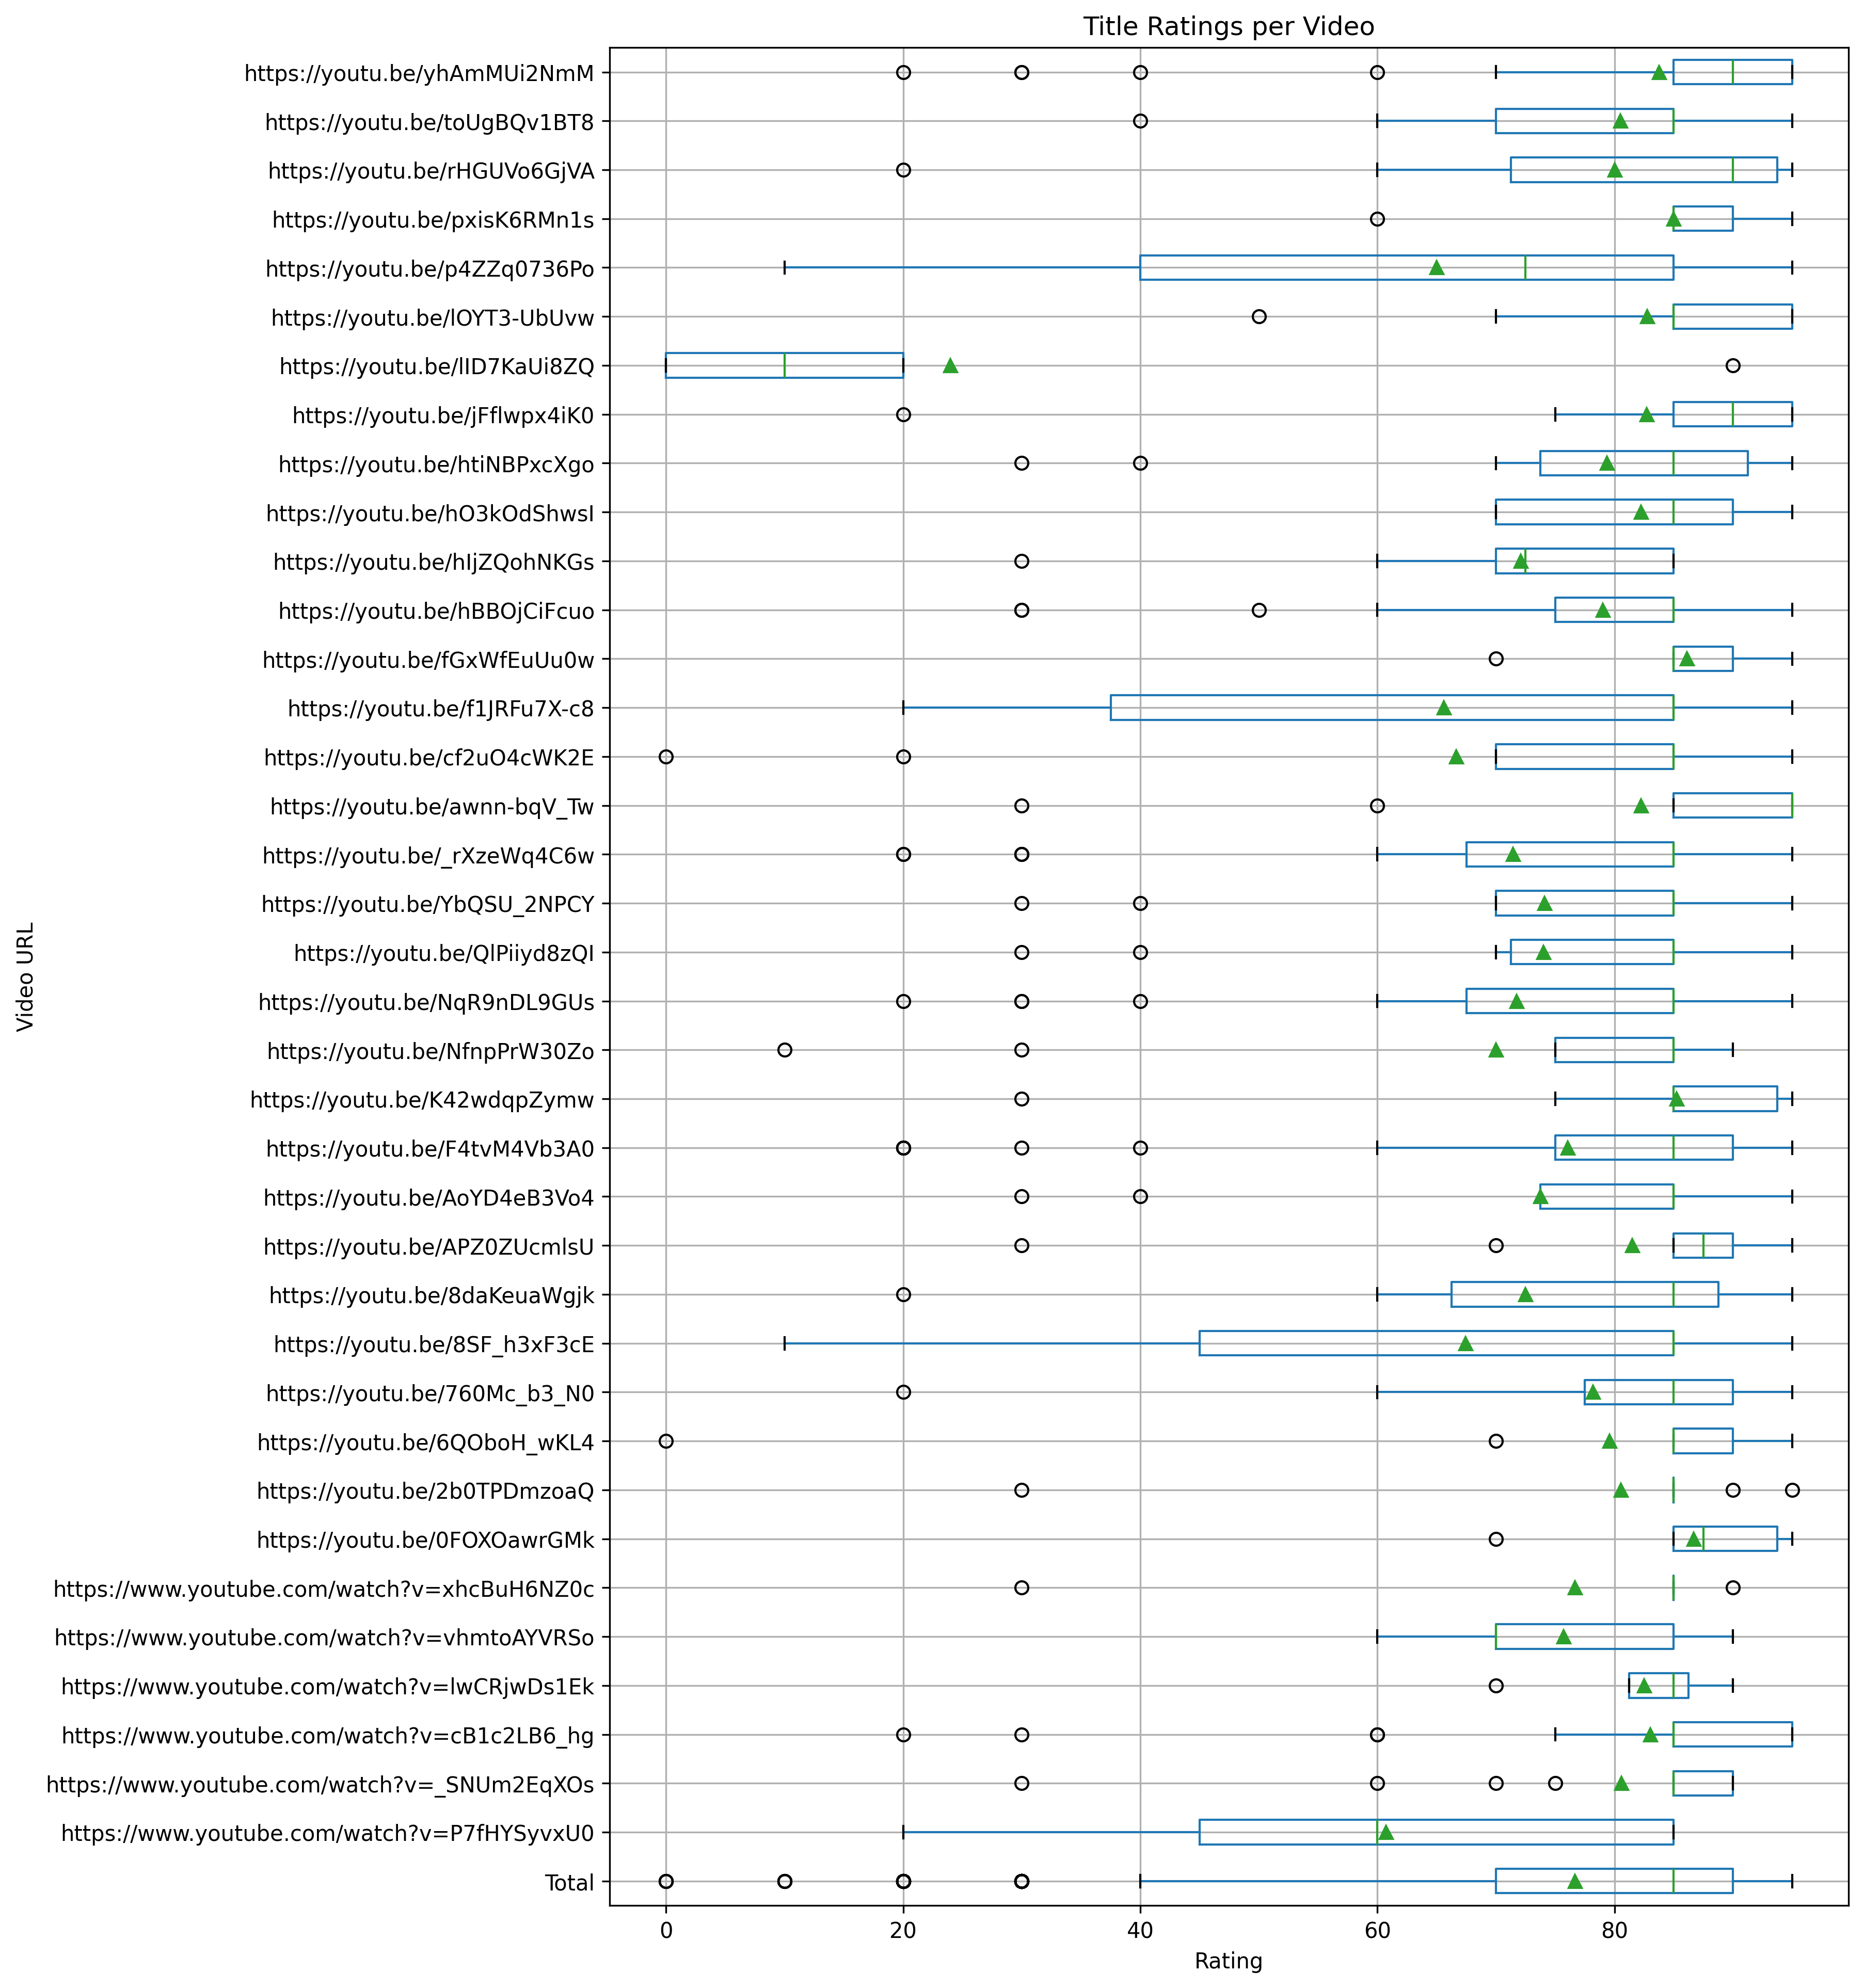

In [19]:
average_ratings_df = human_title_ratings_df.groupby('video_url', as_index=False)['rating'].mean()
average_ratings_df.rename(columns={'rating': 'average_rating'}, inplace=True)
overall_average = average_ratings_df['average_rating'].mean()

overall_row = pd.DataFrame([{'video_url': 'Total Average', 'average_rating': overall_average}])

average_ratings_df = pd.concat([average_ratings_df, overall_row]).reset_index(drop=True)
# We sometimes have ints
average_ratings_df['average_rating'] = average_ratings_df['average_rating'].astype(float).round(2)
display(average_ratings_df)

overall_df = human_title_ratings_df.copy()
overall_df['video_url'] = 'Total'
human_title_ratings_with_overall = pd.concat([human_title_ratings_df, overall_df])

fig, ax = plt.subplots(figsize=(10, 16), dpi=300)
human_title_ratings_with_overall.boxplot(column='rating', by='video_url', vert=False, showmeans=True, ax=ax)
ax.set_title('Title Ratings per Video')
plt.suptitle('')
ax.set_xlabel('Rating')
ax.set_ylabel('Video URL')
plt.show()

Step 3: Rate how well the chapters divide the whole content

In [15]:
chapter_division_ratings_df = pd.DataFrame(columns=['video_url', 'division_type', 'rating', 'arguments'])

for video_url in video_urls:
    chapter_division_ratings_per_video_data = []

    transcripts_video_df = transcripts_df[
        (transcripts_df['video_url'] == video_url)
    ]
    # Sometimes we have wrong datatype for transcript
    transcript_text = ' '.join(transcripts_video_df['transcript'].apply(lambda x: str(x)).tolist())

    human_chapters_transcript_per_video_df = human_chapters_transcript_df[
        human_chapters_transcript_df['video_url'] == video_url]

    human_chapters_str = ''
    for _, chapter in human_chapters_transcript_per_video_df.iterrows():
        human_chapters_str += f"Chapter {chapter.index}:\nTitle: {chapter['title']}\nText: {chapter['chapter_text']}\n\n"

    semantic_chapter_transcript_per_video_df = semantic_chapter_df[
        semantic_chapter_df['video_url'] == video_url]
    
    semantic_chapters_str = ''
    for _, chapter in semantic_chapter_transcript_per_video_df.iterrows():
        semantic_chapters_str += f"Chapter {chapter.index}:\nTitle: {chapter['title']}\nText: {chapter['chapter_text']}\n\n"

    division_rating_prompt = PromptTemplate(
        input_variables=['chapters', 'whole_transcript'],
        partial_variables={'format_instructions': output_parser.get_format_instructions()},
        template="""
Given the entire transcript of a video and its division into chapters with titles and texts, rate how well this division segments the content into coherent and meaningful chapters from 0 to 100, where 0 is the worst and 100 is the best. Provide arguments why the rating is chosen.

Entire Transcript:
{whole_transcript}

Chapters:
{chapters}

{format_instructions}
"""
    )
    
    # Rate human chapter division
    try:
        human_division_response = (division_rating_prompt | structured_model).invoke({
            "chapters": human_chapters_str,
            "whole_transcript": transcript_text
        })
        chapter_division_ratings_per_video_data.append({
            'video_url': video_url,
            'division_type': 'human',
            'rating': human_division_response.rating,
            'arguments': human_division_response.arguments
        })
    except Exception as e:
        print(f"Error rating human chapters division: {e}")
        chapter_division_ratings_per_video_data.append({
            'video_url': video_url,
            'division_type': 'human',
            'rating': None,
            'arguments': str(e)
        })
    
    # Rate semantic chapter division
    try:
        semantic_division_response = (division_rating_prompt | structured_model).invoke({
            "chapters": semantic_chapters_str,
            "whole_transcript": transcript_text
        })
        chapter_division_ratings_per_video_data.append({
            'video_url': video_url,
            'division_type': 'semantic',
            'rating': semantic_division_response.rating,
            'arguments': semantic_division_response.arguments
        })
    except Exception as e:
        print(f"Error rating semantic chapters division: {e}")
        chapter_division_ratings_per_video_data.append({
            'video_url': video_url,
            'division_type': 'semantic',
            'rating': None,
            'arguments': str(e)
        })
    chapter_division_ratings_per_video_df = pd.DataFrame(chapter_division_ratings_per_video_data)
    #print(f"Chapter division ratings for video '{video_url}':")
    #display(chapter_division_ratings_per_video_df)
    chapter_division_ratings_df = pd.concat([chapter_division_ratings_df, chapter_division_ratings_per_video_df]).reset_index(
        drop=True)

Standalone rating of division of transcript into chapters

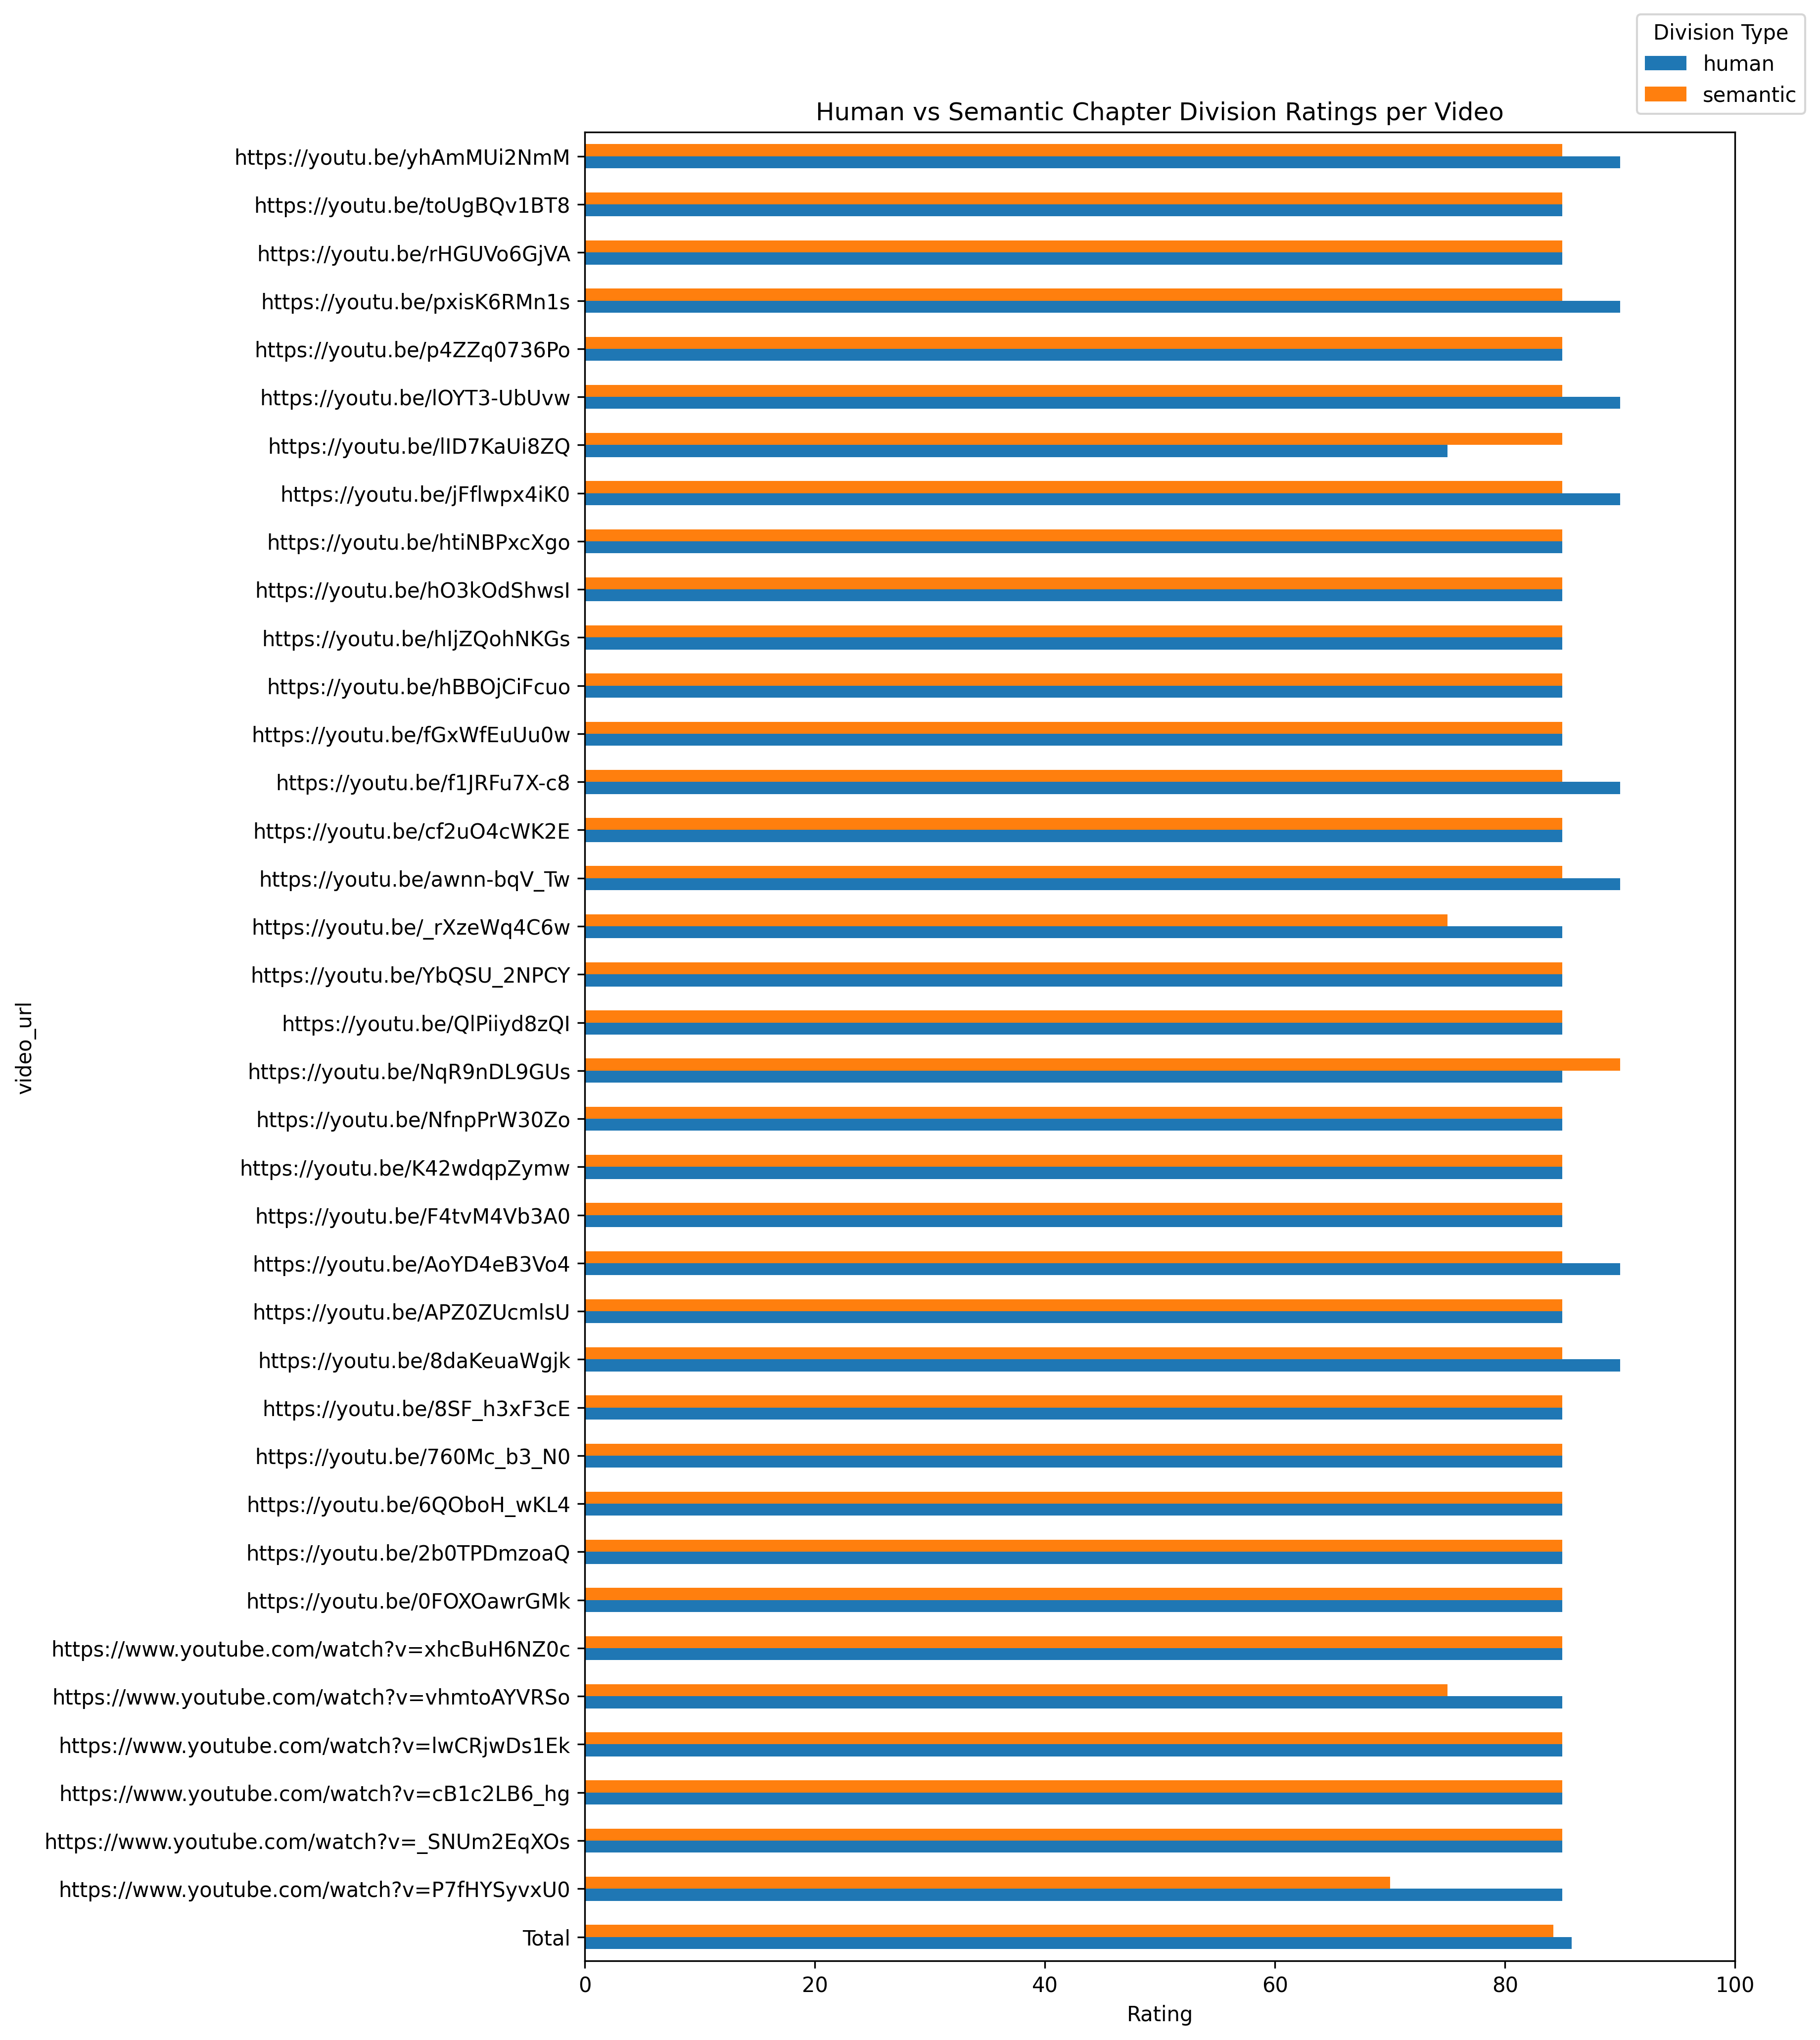

In [41]:
average_ratings_division_df = chapter_division_ratings_df.groupby('division_type', as_index=False)['rating'].mean()

average_ratings_division_df['video_url'] = 'Total'
#average_ratings_division_df.rename(columns={'rating': 'average_rating'}, inplace=True)

#display(average_ratings_division_df)

human_vs_semantic = pd.concat([chapter_division_ratings_df, average_ratings_division_df]).pivot(index='video_url', columns='division_type', values='rating')

fig, ax = plt.subplots(figsize=(10, 16), dpi=300)
human_vs_semantic.plot(kind='barh', ax=ax)
ax.set_title('Human vs Semantic Chapter Division Ratings per Video')
plt.suptitle('')
ax.set_xlim(0, 100)
ax.set_xlabel('Rating')
plt.legend(title='Division Type', loc='upper right', bbox_to_anchor=(1.07, 1.07))
plt.show()

Step 4: Evaluate how much better/worse the semantic chapters are than the human chapters

In [59]:
compare_chapter_division_df = pd.DataFrame(columns=['video_url', 'rating_semantic_better', 'arguments'])

for video_url in video_urls:
    compare_chapter_division_per_video_data = {}

    transcripts_video_df = transcripts_df[
        (transcripts_df['video_url'] == video_url)
    ]
    # Sometimes we have wrong datatype for transcript
    transcript_text = ' '.join(transcripts_video_df['transcript'].apply(lambda x: str(x)).tolist())

    human_chapters_transcript_per_video_df = human_chapters_transcript_df[
        human_chapters_transcript_df['video_url'] == video_url
    ]

    human_chapters_str = ''
    for idx, (_, chapter) in enumerate(human_chapters_transcript_per_video_df.iterrows()):
        human_chapters_str += f"Chapter {idx}:\nText: {chapter['chapter_text']}\n\n"

    semantic_chapter_transcript_per_video_df = semantic_chapter_df[
        semantic_chapter_df['video_url'] == video_url]

    semantic_chapters_str = ''
    for idx, (_, chapter) in enumerate(semantic_chapter_transcript_per_video_df.iterrows()):
        semantic_chapters_str += f"Chapter {chapter.index}:\nText: {chapter['chapter_text']}\n\n"

    comparison_prompt = PromptTemplate(
        input_variables=['human_chapters', 'semantic_chapters', 'whole_transcript'],
        partial_variables={'format_instructions': output_parser.get_format_instructions()},
        template="""
    Given the entire transcript of a video and two different divisions into chapters (Division A and Division B), rate how much better Division B is compared to Division A from 0 to 100, where 0 means Division B is much worse than Division A, 50 means they are equally good, and 100 means Division B is much better than Division A. Provide arguments why the rating is chosen.
    
    Entire Transcript:
    {whole_transcript}
    
    Division A:
    {human_chapters}
    
    Division B:
    {semantic_chapters}
    
    {format_instructions}
    """
    )
    
    # Compare the divisions
    try:
        comparison_response = (comparison_prompt | structured_model).invoke({
            "human_chapters": human_chapters_str,
            "semantic_chapters": semantic_chapters_str,
            "whole_transcript": transcript_text
        })
        compare_chapter_division_per_video_data = {
            'video_url': video_url,
            'rating_semantic_better': comparison_response.rating,
            'arguments': comparison_response.arguments
        }
    except Exception as e:
        print(f"Error comparing divisions: {e}")
        compare_chapter_division_per_video_data = {
            'video_url': video_url,
            'rating_semantic_better': None,
            'arguments': str(e)
        }
    compare_chapter_division_per_video_df = pd.DataFrame(compare_chapter_division_per_video_data, index=[0])
    print(f"Chapter division ratings for video '{video_url}':")
    total_semantic_better = compare_chapter_division_per_video_data["rating_semantic_better"]
    if total_semantic_better < 50:
            print(f"    Semantic chapter division is {total_semantic_better}% worse than human chapter division")
    elif total_semantic_better > 50:
        print(f"    Semantic chapter division is {total_semantic_better - 50}% better than human chapter division")
    else:
        print(f"    Semantic chapter division is equally good to human chapter division")
    print(f"    The reason for the rating is:\n{compare_chapter_division_per_video_data['arguments'][:320]}...")
    print("-" * 100)
    compare_chapter_division_df = pd.concat(
        [compare_chapter_division_df, compare_chapter_division_per_video_df]).reset_index(
        drop=True)

Chapter division ratings for video 'https://youtu.be/F4tvM4Vb3A0':
    Semantic chapter division is 20% better than human chapter division
    The reason for the rating is:
Division B is rated 70 compared to Division A because it provides a more logical and coherent structure for the video tr...
----------------------------------------------------------------------------------------------------
Chapter division ratings for video 'https://youtu.be/toUgBQv1BT8':
    Semantic chapter division is 10% better than human chapter division
    The reason for the rating is:
Division B is slightly better than Division A because it breaks down the content into smaller, more manageable chapters....
----------------------------------------------------------------------------------------------------
Chapter division ratings for video 'https://www.youtube.com/watch?v=lwCRjwDs1Ek':
    Semantic chapter division is 10% better than human chapter division
    The reason for the rating is:
Division B is sl

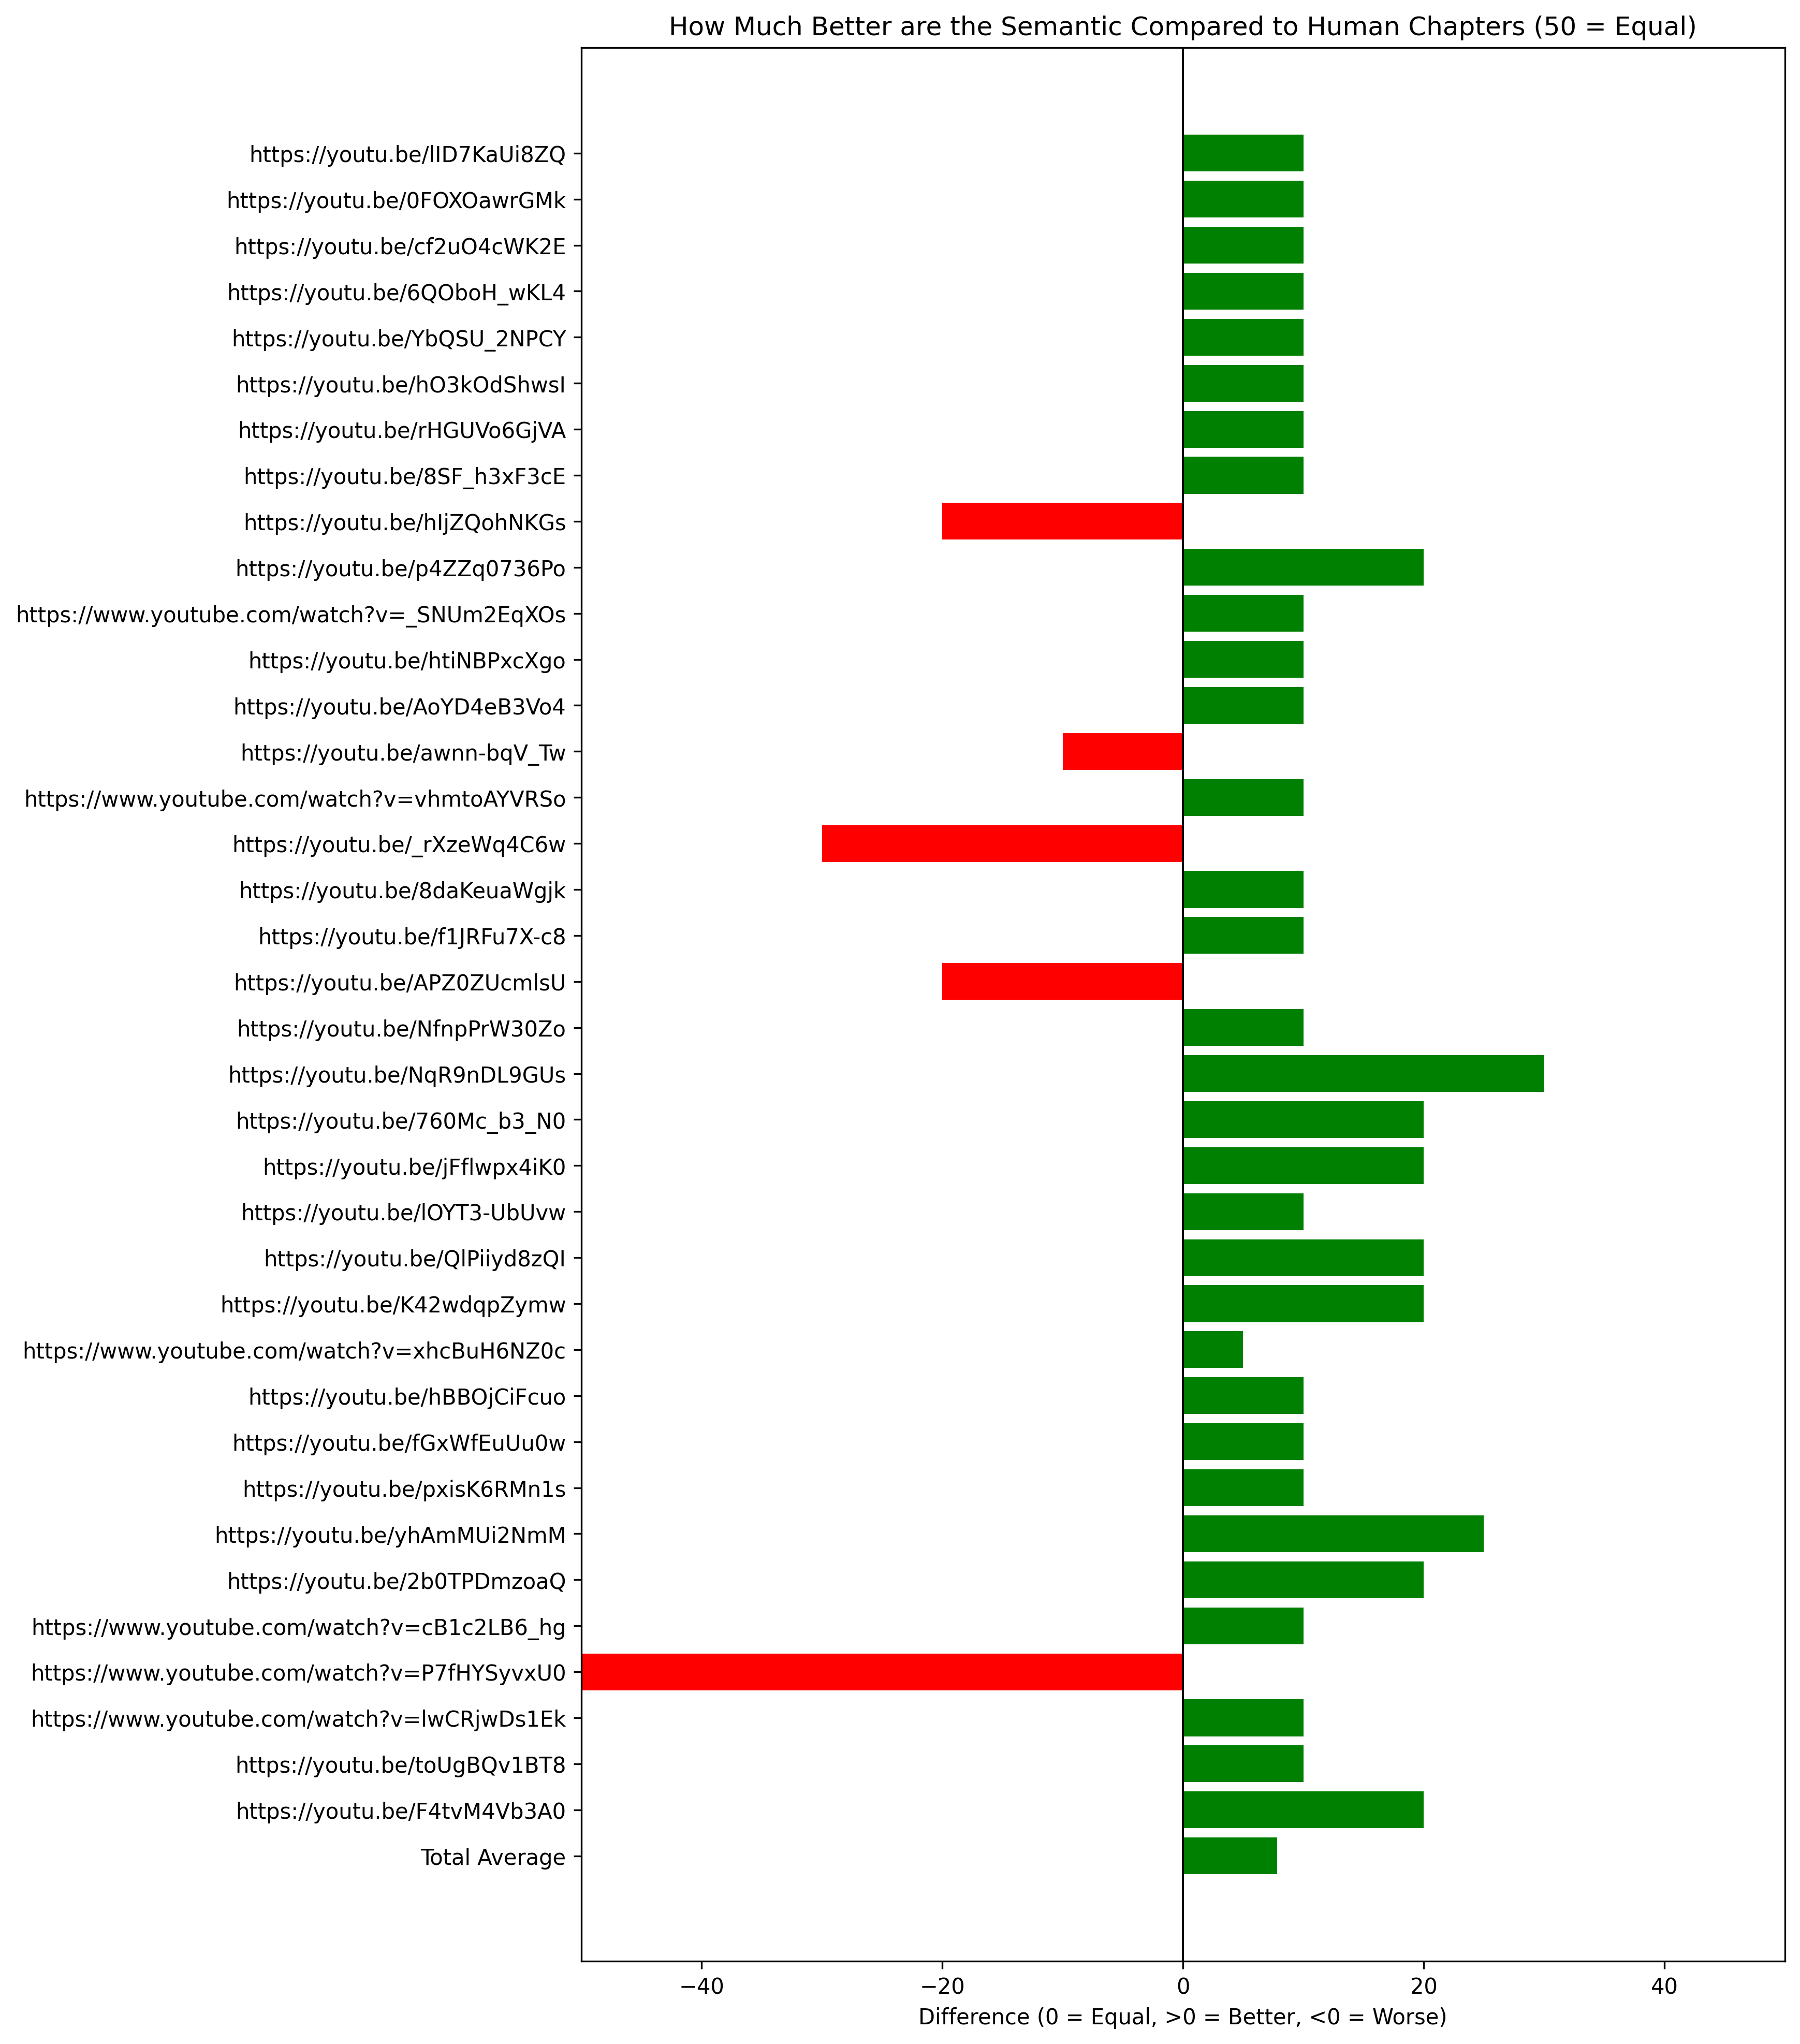

In [60]:
total_average = compare_chapter_division_df['rating_semantic_better'].mean()

compare_chapter_division_with_total_avg = pd.concat([
    pd.DataFrame({'video_url': 'Total Average', 'rating_semantic_better': total_average, 'arguments': ''}, index=[0]),
    compare_chapter_division_df
]).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 16), dpi=300)

bars = ax.barh(compare_chapter_division_with_total_avg['video_url'],
               compare_chapter_division_with_total_avg['rating_semantic_better'] - 50,
               color=['green' if rating > 50 else 'red' for rating in
                      compare_chapter_division_with_total_avg['rating_semantic_better']])

ax.axvline(0, color='black', linewidth=1)
ax.set_title('How Much Better are the Semantic Compared to Human Chapters (50 = Equal)')
ax.set_xlabel('Difference (0 = Equal, >0 = Better, <0 = Worse)')
ax.set_xlim(-50, 50)
plt.show()

Comparison between semantic chapter vs human chapter division

In [61]:
total_semantic_better = compare_chapter_division_df['rating_semantic_better'].mean()

if total_semantic_better < 50:
    print(f"Semantic chapter division is {total_semantic_better.round(2)}% worse than human chapter division")
elif total_semantic_better > 50:
    print(f"Semantic chapter division is {(total_semantic_better - 50).round(2)}% better than human chapter division")
else:
    print(f"Semantic chapter division is equally good to human chapter division")

Semantic chapter division is 7.84% better than human chapter division
